# Capstone Project: Singapore HDB Resale Price Prediction
___

<p align = 'center'>
  <img src = "https://github.com/ElangSetiawan/sg-hdb-resale/blob/main/images/hdb_shintaro_tay_st_photo.jpg?raw=true" width = 75%>
<p/>
Source : https://www.straitstimes.com/singapore/housing/households-that-received-help-with-mortgage-payments-nearly-triple-that-of-same


**Problem Statement**

Public housing in Singapore is subsidised housing built and managed by the government under the Housing and Development Board (HDB). Most public housing in Singapore is owner-occupied. Under Singapore’s housing ownership programme, housing units are sold to applicants who meet certain income, citizenship and property ownership requirements, on a 99-year leasehold. The estate’s land and common areas continue to be owned by the government. Owner-occupied public housing can be sold to others in a resale market, subject to certain restrictions. Prices within the resale market are not regulated by the government.

Demand for resale flats since the end of the Circuit Breaker has pushed prices and sales to new highs. According to the HDB Price Index in Q2 2021, resale flat prices climbed 3% from Q1 2021, growing for the fifth consecutive quarter since Q2 2020. Prices were also 11% higher compared to a year ago. As data scientists, we want to understand the factors driving the price of resale flats as and provide predicted sale price for property portals.

**Model Explored**

|Models|Description|
|---|---|
|LinearRegression|
|XGBRegressor|


**Evaluation Metrics**

The evaluation metrics will be overfitting/underfitting of less than 2% between train and test data.

**Workflow Process**  
1. Notebook 1 of 2 : General EDA
2. Notebook 1 of 2 : Geolocation preprocessing


**Data Sources**  
1. Singapore postal sector and districts:<br> 
https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm
2. Singapore HDB information and resale prices<br>
https://data.gov.sg/dataset/hdb-property-information<br>
https://data.gov.sg/dataset/resale-flat-prices
3. Singapore primary schools<br>
https://en.wikipedia.org/wiki/List_of_schools_in_Singapore
4. Singapore MRT<br>
https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations
5. Singapore LRT<br>
https://en.wikipedia.org/wiki/List_of_Singapore_LRT_stations
6. Singapore Shopping Malls<br>
https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore
6. Ministry of Education - Primary School Balloting system<br>
https://www.moe.gov.sg/primary/p1-registration/distance

**HDB information and resale transaction prices**
The site data.gov.sg provides both the hdb information dataset as well as the monthly resale transactions. Since old transaction data does not improve the model only dataset from 2017 is considered for this project.

**Geolocation and point of interests**
In this project, it is hypothesized that distance of hdb flat to nearby amenities such as MRT/LRT stations, schools, and shopping centres will be important, these geo informations are obtained via API from https://developers.onemap.sg/commonapi/search? since this provides free geolocation data unlike google map.<br>
In Singapore context, postal codes are classified into 28 different districts. A mapping table is created for this.

# 1.0 Python Libraries

In [1]:
# # installing less common packages (uncomment if you do not have these installed)
# !pip install geopy
# !pip install geopandas
# !pip install featuretools

In [2]:
# The following code imports the standard required libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from geopandas import GeoDataFrame
from pyproj import Geod

import folium

import json 
import requests
import time

import datetime as dt

import shapely
from shapely import geometry
from shapely import ops
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points

from sklearn.base import BaseEstimator, TransformerMixin


import warnings
# warnings.filterwarnings('ignore')

sns.set_style('ticks')

pd.set_option('display.max_columns', None)

%matplotlib inline

# 1.1 Geolocation Helper Functions

In [3]:
# The following code is helper functions to be used in a scikit-learn pipeline
# Reference: https://www.kaggle.com/lucabasa/understand-and-use-a-pipeline#A-Pipeline-step-by-step


def convert_list_to_string(org_list, separator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return separator.join(org_list)

def clean_string(in_string):
    """ Remove characters in string that cause an error in onemap_api """
    out_string = ' ' + in_string.upper() + ' '
    out_string = out_string.replace("'","%27").replace(" ST. "," SAINT ").replace(" RD "," ROAD "). \
                           replace(" ST "," STREET ").replace(" AVE "," AVENUE ").replace(" PK "," PARK "). \
                           strip().replace(" ","%20")
    
    return out_string

def get_onemap_api(address):
    """ Given a string address, call the onemap API to obtain the geodata """
    qry = clean_string(address)
    req = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+qry+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    resultsdict = eval(req.text)
    if resultsdict['found']>0:
        latitude = float(resultsdict['results'][0]['LATITUDE'])
        longitude = float(resultsdict['results'][0]['LONGITUDE'])
        if resultsdict['results'][0]['POSTAL'] == 'NIL':
            postal = 0
        else:
            postal = int(resultsdict['results'][0]['POSTAL'])
        return resultsdict['found'], latitude, longitude, postal, resultsdict['results'][0]['ADDRESS']  

    else:
        return resultsdict['found'], 0.0, 0.0, 0, qry
    

class get_location(BaseEstimator, TransformerMixin):
    '''
    This class takes in a dataframe containing a column 'address' of the address to be geocoded.
    New columns will be added (if not existing), otherwise the columns will be populated with the 
    latitude, longitude, postal_adress, postcode, district, point.
    '''
    def __init__(self, overwrite=False, verbose=True, maxrows=10):
        self.overwrite = overwrite # If True, existing location data is overwritten, skip otherwise
        self.verbose = verbose     # If True, write some debug code
        self.maxrows = maxrows     # Limit number of rows queried
        self.geo_columns = ['latitude','longitude','postcode','mailing_address','district','point']

    def fit(self, X, y=None):
        # Do nothing
        return self
    
    # The following checks if the list of geo_columns exists in the dataframe and creates the columns if not 
    def match_columns(self, X):
        miss_cols = list(set(self.geo_columns) - set(X.columns))
        
        err = 0
        
        if len(miss_cols) > 0:
            for col in miss_cols:
                if col == 'latitude' or col == 'longitude':
                    X[col] = 0.0  # insert a column for the missing latitude/longitude as float64
                elif col == 'postcode' or col == 'district':
                    X[col] = 0    # insert a column for the missing postcode/district as int64
                elif col == 'mailing_address':
                    X[col] = 'Not Found'   # insert an address column as string
                else:
                    X[col] = 0
                err += 1
                      
        if err > 0 and self.verbose == True:
            print('Columns ' + convert_list_to_string(miss_cols, ', ') + ' are added.')
            
        return X
        
    def transform(self, X):
        result = 0
        count = 0
        failed_count = 0
        skipped_count = 0
        
        X = self.match_columns(X)
        
        i_addr = X.columns.get_loc('address')
        i_lat  = X.columns.get_loc('latitude')
        i_lon  = X.columns.get_loc('longitude')
        i_post = X.columns.get_loc('postcode')
        i_mail = X.columns.get_loc('mailing_address')
        i_dist = X.columns.get_loc('district')
        i_point = X.columns.get_loc('point')
        
        for i in range(self.maxrows):
            if self.overwrite == True or (X.iloc[i,i_lat] == 0.0 and X.iloc[i,i_lon] == 0.0): 
                result, X.iloc[i,i_lat], X.iloc[i,i_lon], X.iloc[i,i_post], X.iloc[i,i_mail] \
                     = get_onemap_api(X.iloc[i,i_addr])
                if result > 0:
                    X.iloc[i,i_dist] = sg_districts[X.iloc[i,i_post]//10000] 
                    X.iloc[i,i_point] = Point(X.iloc[i,i_lon], X.iloc[i,i_lat])
                else:
                    failed_count = failed_count + 1
                    if self.verbose == True:
                        print('Failed to get geodata for: '+ X.iloc[i,i_addr])
            else:
                skipped_count = skipped_count + 1

            count = count + 1

            if count%100 == 0 and count > skipped_count:
                time.sleep(1) # Sleep 1 second after each 100 iterations
                
            if self.verbose == True and count%1000 == 0:
                print('Processed: ' + str(count) + ' addresses, ' + str(failed_count) + ' failed, ' 
                  + str(skipped_count) + ' skipped.')

        if self.verbose == True:
            print('Processed: ' + str(count) + ' addresses, ' + str(failed_count) + ' failed, ' 
                  + str(skipped_count) + ' skipped.')

        return X
    

# 1.2 Mapping Helper Functions

In [4]:
# Helper functions for mapping the geolocations
# This is the center of Singapore in latitude and longitude
sg_lat = 1.28967
sg_lon = 103.85007

def marker_circle(X, the_map):
    """Creates markers for all `coordinates` passed, and adds onto `the_map`.  """
    i_addr = X.columns.get_loc('address')
    i_lat  = X.columns.get_loc('latitude')
    i_lon  = X.columns.get_loc('longitude')
    i_post = X.columns.get_loc('postcode')
    i_mail = X.columns.get_loc('mailing_address')
    i_dist = X.columns.get_loc('district')
    i_point = X.columns.get_loc('point')

    for i in range(len(X)):
        folium.CircleMarker(location = [X.iloc[i,i_lat],X.iloc[i,i_lon]],
                  radius=1.0,
                  popup=X.iloc[i,i_mail]).add_to(the_map)
        
def marker_icons(X, the_map, color='red', icon='arrow-down' ):
    """Creates markers for all points passed, and adds onto `the_map`.  """
    i_addr = X.columns.get_loc('address')
    i_lat  = X.columns.get_loc('latitude')
    i_lon  = X.columns.get_loc('longitude')
    i_post = X.columns.get_loc('postcode')
    i_mail = X.columns.get_loc('mailing_address')
    i_dist = X.columns.get_loc('district')
    i_point = X.columns.get_loc('point')
    iconprefix = 'fa'
    iconname=icon
    
    for i in range(len(X)):
        folium.Marker(location = [X.iloc[i,i_lat],X.iloc[i,i_lon]],
                  popup=X.iloc[i,i_mail], 
                  icon=folium.Icon(color=color ,prefix= iconprefix, icon=iconname )).add_to(the_map)
    

# 1.3 Features Helper Functions

In [5]:
# Helper functions for feature engineering

def make_features(X):
    """Apply feature engineering to add relevant columns  """

    X['sale_date'] = pd.to_datetime(X['month']+'-01')
    X['lease_date'] = pd.to_datetime(X['lease_commence_date'].astype(str), format='%Y')
    X['lease_left'] = 99 - (X.sale_date.dt.year - X.lease_date.dt.year)
    X['price_psf']  = X['resale_price'] / X['floor_area_sqm'] / 10.7639 # Is this data leak?
    return X

class get_nearby(BaseEstimator, TransformerMixin):
    '''
    This class takes in a dataframe containing a column 'address'.
    New columns will be added (if not existing), otherwise the columns will be populated with the 
    nearby_mrt   : Number of MRT stations within 1 km
    nearby_school: Number of Primary schools within 1 km
    nearby_shop  : Number of Shopping centers within 1 km
    '''
    dummy = pd.DataFrame()
    def __init__(self, verbose=True, maxrows=10, max_km = 1.0, mrt=dummy, school=dummy, shop=dummy):
        self.verbose = verbose     # If True, write some debug code
        self.maxrows = maxrows     # Limit number of rows queried
        self.mrt = mrt             # Lookup for MRT and LRT geolocations
        self.school = school       # lookup for School geolocations
        self.shop = shop           # Lookup for Shopping center geolocations
        self.max_km = max_km       # Maximum distance to be considered nearby, default to 1km
        self.geo_columns = ['nearby_mrt','nearby_school','nearby_shop']

    def fit(self, X, y=None):
        # Do nothing
        return self
    
    # The following checks if the list of geo_columns exists in the dataframe and creates the columns if not 
    def match_columns(self, X):
        miss_cols = list(set(self.geo_columns) - set(X.columns))
        
        err = 0
        
        if len(miss_cols) > 0:
            for col in miss_cols:
                X[col] = 0    # insert an int64 column for the missing 'nearby' column
                err += 1
                      
        if err > 0 and self.verbose == True:
            print('Columns ' + convert_list_to_string(miss_cols, ', ') + ' are added.')
            
        return X
        
    def transform(self, X):

        count = 0
        
        X = self.match_columns(X) # Add the missing columns if any

        M = self.mrt     # dataset for MRT/LRT lookup
        P = self.school  # dataset for primary school lookup
        S = self.shop    # dataset for shopping center lookup
        geod     = Geod(ellps="WGS84") # Onemap uses this projection
        
        i_addr   = X.columns.get_loc('address')
        i_point  = X.columns.get_loc('point')
        i_mrt    = X.columns.get_loc('nearby_mrt')
        i_school = X.columns.get_loc('nearby_school')
        i_shop   = X.columns.get_loc('nearby_shop')
        m_addr   = M.columns.get_loc('address')
        m_point  = M.columns.get_loc('point')
        p_addr   = P.columns.get_loc('address')
        p_point  = P.columns.get_loc('point')
        s_addr   = S.columns.get_loc('address')
        s_point  = S.columns.get_loc('point')
        
        for i in range(self.maxrows):  # For each rows in X
            a = X.iloc[i,i_point]      # The location of the HDB flat
            
            m_count = 0
            for m in range(len(M)):    # Calculate distance of the flat to each of the MRT/LRT stations
                b = M.iloc[m,m_point]  # location of the station
                distance = geod.geometry_length(LineString([a, b]))/1000 # Distance in km
                if (distance <= self.max_km): # Count if distance is less than or equal to the max_km
                    m_count = m_count + 1
            X.iloc[i,i_mrt] = m_count  # Record as number of nearby MRT/LRT stations
            
            p_count = 0
            for p in range(len(P)):    # Calculate distance of the flat to each primary school
                b = P.iloc[p,p_point]  # location of the school
                distance = geod.geometry_length(LineString([a, b]))/1000 # Distance in km
                if (distance <= self.max_km): # Count if distance is less than or equal to the max_km
                    p_count = p_count + 1
            X.iloc[i,i_school] = p_count  # Record as number of nearby schools
                    
            s_count = 0
            for s in range(len(S)):    # Calculate distance of the flat to each shopping centers
                b = S.iloc[s,s_point]  # location of the shopping center
                distance = geod.geometry_length(LineString([a, b]))/1000 # Distance in km
                if (distance <= self.max_km): # Count if distance is less than or equal to the max_km
                    s_count = s_count + 1
            X.iloc[i,i_shop] = s_count # Record as number of nearby shopping centers

            count = count + 1

            if self.verbose == True and count%1000 == 0:
                print('Processed: ' + str(count) + ' addresses.')

        if self.verbose == True:
            print('Processed: ' + str(count) + ' addresses in total.')

        return X

# 1.4 Univariate EDA Helper Functions

In [6]:
# distribution plots (histogram, boxplot, probplot)
def dist_plots(df, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize=(15, nrows*3.5))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.distplot(df[col], ax = ax[i*3-3], fit = stats.norm)
        ax[i*3-3].set_title(f'{col} distribution plot',fontsize=14)
        ax[i*3-3].tick_params(labelsize=12)
        ax[i*3-3].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*3-2].set_title(f'{col} box plot',fontsize=14)
        ax[i*3-2].tick_params(labelsize=12)
        ax[i*3-2].set_xlabel(col, fontsize=14)
        
        stats.probplot(df[col], plot = ax[i*3-1])
        ax[i*3-1].set_title(f'{col} probability plot', fontsize=14)
        ax[i*3-1].tick_params(labelsize=12)
        ax[i*3-1].set_xlabel(col, fontsize=14)
    plt.tight_layout()

# 2.0 Data Import
___
Import the dataset into python. Input files from data.gov.sg as referenced above or manually created from wikipedia information as referenced above.

In [7]:
# 2.1 HDB flat information - Location information
df_raw_property_info = pd.read_csv('../data/raw/hdb-property-information.csv')
print(df_raw_property_info.shape)
print(df_raw_property_info.columns)

(12442, 24)
Index(['blk_no', 'street', 'max_floor_lvl', 'year_completed', 'residential',
       'commercial', 'market_hawker', 'miscellaneous', 'multistorey_carpark',
       'precinct_pavilion', 'bldg_contract_town', 'total_dwelling_units',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental'],
      dtype='object')


In [8]:
# 2.2 HDB flat information - Resale Prices
# Coverage up to 2021-11-23 - data.gov.sg
df_raw_2017 = pd.read_csv('../data/raw/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')
print(df_raw_2017.shape)
print(df_raw_2017.columns)

(113753, 11)
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')


In [9]:
# Points of Interest
# 2.3 MRT and LRT locations
df_raw_mrt_lrt = pd.read_csv('../data/raw/Singapore_MRT_LRT_stations.csv')
print(df_raw_mrt_lrt.shape)
print(df_raw_mrt_lrt.columns)

(166, 2)
Index(['station_id', 'station_name'], dtype='object')


In [10]:
# 2.4 Primary School locations
df_raw_schools = pd.read_csv('../data/raw/Singapore_Primary_schools.csv')
print(df_raw_schools.shape)
print(df_raw_schools.columns)

(184, 1)
Index(['name'], dtype='object')


In [11]:
# 2.5 Shopping mall locations
df_raw_shopping = pd.read_csv('../data/raw/Singapore_Shopping.csv')
print(df_raw_shopping.shape)
print(df_raw_shopping.columns)

(153, 1)
Index(['name'], dtype='object')


In [12]:
# 2.6 Mapping of postcode to districts
def keystoint(x):
    return {int(k): int(v) for k, v in x}
with open('../data/raw/Singapore_districts.json') as d:
    sg_districts = json.load(d, object_pairs_hook=keystoint)
    print(sg_districts)
    print(type(sg_districts))


{0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 14: 3, 15: 3, 16: 3, 9: 4, 10: 4, 11: 5, 12: 5, 13: 5, 17: 6, 18: 7, 19: 7, 20: 8, 21: 8, 22: 9, 23: 9, 24: 10, 25: 10, 26: 10, 27: 10, 28: 11, 29: 11, 30: 11, 31: 12, 32: 12, 33: 12, 34: 13, 35: 13, 36: 13, 37: 13, 38: 14, 39: 14, 40: 14, 41: 14, 42: 15, 43: 15, 44: 15, 45: 15, 46: 16, 47: 16, 48: 16, 49: 17, 50: 17, 81: 17, 51: 18, 52: 18, 53: 19, 54: 19, 55: 19, 82: 19, 56: 20, 57: 20, 58: 21, 59: 21, 60: 22, 61: 22, 62: 22, 63: 22, 64: 22, 65: 23, 66: 23, 67: 23, 68: 23, 69: 24, 70: 24, 71: 24, 72: 25, 73: 25, 77: 26, 78: 26, 75: 27, 76: 27, 79: 28, 80: 28}
<class 'dict'>


# 3.0 General EDA
___

In [13]:
# getting some basic information about each dataframe
# shape of dataframe i.e. number of rows and columns
# total number of rows with null values
# total number of duplicates
# data types of columns

def assess_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the percentage of NA values in each column.
    The column names are noted on the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA

def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print('Data Type of the columns')
    print(df.dtypes)
    print()
    
    df_NA = assess_NA(df)
    if len(df_NA) > 0:
        print('Missing value for each columns:')
        print(df_NA)
    else:
        print('There is no missing value.')
    print()
    
    print('Statistics for numerical columns')
    print(df.describe())
    print()
    
    print('Top 5 rows')
    print(df.head(5))
    print("-----\n")

In [14]:
basic_eda(df_raw_property_info, 'hdb property info')

HDB PROPERTY INFO

Rows: 12442 	 Columns: 24

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 0
Percentage dupe rows: 0.0%

Data Type of the columns
blk_no                   object
street                   object
max_floor_lvl             int64
year_completed            int64
residential              object
commercial               object
market_hawker            object
miscellaneous            object
multistorey_carpark      object
precinct_pavilion        object
bldg_contract_town       object
total_dwelling_units      int64
1room_sold                int64
2room_sold                int64
3room_sold                int64
4room_sold                int64
5room_sold                int64
exec_sold                 int64
multigen_sold             int64
studio_apartment_sold     int64
1room_rental              int64
2room_rental              int64
3room_rental              int64
other_room_rental         int64
dtype: object

There is no missing value.

Statistics for nume

The eda report shows that there is no missing data.

The following columns are categorical columns for label encoding:
residential, commercial, market_hawker, miscellaneous, multistorey_carpark, precinct_pavilion, bldg_contract_town

In [15]:
basic_eda(df_raw_2017, 'Prices from 1/1/2017 to 23/11/2021')

PRICES FROM 1/1/2017 TO 23/11/2021

Rows: 113753 	 Columns: 11

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 494
Percentage dupe rows: 0.43%

Data Type of the columns
month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

There is no missing value.

Statistics for numerical columns
       floor_area_sqm  lease_commence_date  resale_price
count   113753.000000        113753.000000  1.137530e+05
mean        97.855562          1995.004492  4.578275e+05
std         24.149495            13.394424  1.584956e+05
min         31.000000          1966.000000  1.400000e+05
25%         82.000000          1985.000000  3.420000e+05
50%         95.000000          1995.000000  4.2700

The eda report shows that there is no missing data.
There are 494 duplicate rows detected, since this represent 0.43% of the overal dataset, these duplicates will be removed.

Lease commence date needs to be converted to datetime 
Month needs to be converted to datetime
Remaining lease to be coverted to number of years remaining in the lease

The following columns are categorical columns for one hot encoding:
flat_type, storey_range, flat_model.

In [16]:
# Explore the categorical columns

print(df_raw_2017.flat_type.value_counts())
print()
print(df_raw_2017.storey_range.value_counts())
print()
print(df_raw_2017.flat_model.value_counts())

4 ROOM              47328
5 ROOM              28946
3 ROOM              26596
EXECUTIVE            9090
2 ROOM               1687
MULTI-GENERATION       58
1 ROOM                 48
Name: flat_type, dtype: int64

04 TO 06    26340
07 TO 09    23785
10 TO 12    21196
01 TO 03    20279
13 TO 15    10864
16 TO 18     5049
19 TO 21     2165
22 TO 24     1605
25 TO 27      898
28 TO 30      566
31 TO 33      288
34 TO 36      268
37 TO 39      254
40 TO 42      128
43 TO 45       31
46 TO 48       27
49 TO 51       10
Name: storey_range, dtype: int64

Model A                   37337
Improved                  28466
New Generation            14746
Premium Apartment         12996
Apartment                  4572
Simplified                 4478
Maisonette                 3436
Standard                   3229
DBSS                       2161
Model A2                   1349
Adjoined flat               214
Model A-Maisonette          204
Type S1                     204
Type S2                     118

# 4.0 Feature Engineering part 1
___

| Observations | Action |
|---|---|
|Column 'month' is text yyyy-mm | Create new 'sale_date' column of datetime yyyy-mm-01 |
|Column 'remaining_lease" is text | Create new 'remaining_year' column of 99 - (sale_date.year - lease_commence_date)|

### 4.1 Remove duplicate data
___

In [17]:
# Clean up the prices - remove duplicated rows
df_price = df_raw_2017.copy()
duplicate = df_price[df_price.duplicated(keep=False)]
duplicate

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
224,2017-01,BUKIT MERAH,4 ROOM,106,HENDERSON CRES,07 TO 09,81.0,Improved,1975,57 years,470000.0
243,2017-01,BUKIT MERAH,4 ROOM,106,HENDERSON CRES,07 TO 09,81.0,Improved,1975,57 years,470000.0
304,2017-01,CENTRAL AREA,3 ROOM,271,QUEEN ST,16 TO 18,68.0,Improved,1979,61 years 02 months,470000.0
305,2017-01,CENTRAL AREA,3 ROOM,271,QUEEN ST,16 TO 18,68.0,Improved,1979,61 years 02 months,470000.0
505,2017-01,JURONG EAST,4 ROOM,265,TOH GUAN RD,04 TO 06,101.0,Model A,1998,80 years 09 months,470000.0
...,...,...,...,...,...,...,...,...,...,...,...
110722,2021-10,QUEENSTOWN,3 ROOM,5,GHIM MOH RD,04 TO 06,65.0,Improved,1976,53 years 10 months,335000.0
111338,2021-10,TOA PAYOH,3 ROOM,234,LOR 8 TOA PAYOH,07 TO 09,65.0,Improved,1976,54 years,285000.0
111340,2021-10,TOA PAYOH,3 ROOM,234,LOR 8 TOA PAYOH,07 TO 09,65.0,Improved,1976,54 years,285000.0
111460,2021-10,WOODLANDS,4 ROOM,429,WOODLANDS ST 41,07 TO 09,84.0,Simplified,1996,73 years 11 months,360000.0


In [18]:
print('Shape before duplicate removal:', df_price.shape)
df_price.drop_duplicates(keep='first', inplace=True)
print('Shape after duplicate removal:', df_price.shape)

Shape before duplicate removal: (113753, 11)
Shape after duplicate removal: (113506, 11)


### 4.1 Basic Features Engineering
___

In [19]:
# New column 'sale_date' as datetime.

df_price = make_features(df_price)
df_price.head(-3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,sale_date,lease_date,lease_left,price_psf
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017-01-01,1979-01-01,61,489.852867
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017-01-01,1978-01-01,60,346.653470
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017-01-01,1980-01-01,62,363.292836
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017-01-01,1980-01-01,62,362.048962
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017-01-01,1980-01-01,62,367.452678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113745,2021-11,YISHUN,EXECUTIVE,387,YISHUN RING RD,04 TO 06,146.0,Maisonette,1988,65 years 08 months,688000.0,2021-11-01,1988-01-01,66,437.790092
113746,2021-11,YISHUN,EXECUTIVE,328,YISHUN RING RD,01 TO 03,146.0,Maisonette,1988,65 years 08 months,668000.0,2021-11-01,1988-01-01,66,425.063635
113747,2021-11,YISHUN,EXECUTIVE,361,YISHUN RING RD,01 TO 03,146.0,Maisonette,1988,65 years 08 months,668000.0,2021-11-01,1988-01-01,66,425.063635
113748,2021-11,YISHUN,EXECUTIVE,792,YISHUN RING RD,10 TO 12,144.0,Apartment,1987,64 years 10 months,690000.0,2021-11-01,1987-01-01,65,445.160831


### 4.2 Geocoding the addresses
___

In [20]:
# Create the df_mrt_lrt dataset for MRT/LRT Information with geo location
df_mrt_lrt = df_raw_mrt_lrt.copy()
df_mrt_lrt['address'] = df_mrt_lrt['station_id']
print(f'Processing {len(df_mrt_lrt)} rows.')
finder = get_location(overwrite=True, verbose=True, maxrows=len(df_mrt_lrt))
df_mrt_lrt = finder.fit_transform(df_mrt_lrt)
df_mrt_lrt.head(100)

Processing 166 rows.
Columns mailing_address, postcode, district, point, longitude, latitude are added.
Processed: 166 addresses, 0 failed, 0 skipped.


,station_id,station_name,address,mailing_address,postcode,district,point,longitude,latitude
0,NS10,Admiralty,NS10,70 WOODLANDS AVENUE 7 ADMIRALTY MRT STATION (N...,738344,25,POINT (103.800990519771 1.44058856161847),103.800991,1.440589
1,EW9,Aljunied,EW9,81 LORONG 25 GEYLANG ALJUNIED MRT STATION (EW9...,388310,14,POINT (103.882906044385 1.3164326118157),103.882906,1.316433
2,NS16,Ang Mo Kio,NS16,2795 ANG MO KIO AVENUE 8 ANG MO KIO MRT STATIO...,569812,20,POINT (103.84955809232 1.36993284962262),103.849558,1.369933
3,CC12,Bartley,CC12,90 BARTLEY ROAD BARTLEY MRT STATION (CC12) SIN...,539788,19,POINT (103.880177899184 1.34250117805245),103.880178,1.342501
4,CE1,Bayfront,CE1,11 BAYFRONT AVENUE BAYFRONT MRT STATION (DT16 ...,18957,1,POINT (103.859079764874 1.28187378879209),103.859080,1.281874
...,...,...,...,...,...,...,...,...,...
95,NS11,Sembawang,NS11,11 CANBERRA ROAD SEMBAWANG MRT STATION (NS11) ...,759775,27,POINT (103.820046140211 1.44905082158502),103.820046,1.449051
96,NE16,Sengkang,NE16,5 SENGKANG SQUARE SENGKANG MRT STATION (NE16) ...,545062,19,POINT (103.895484694279 1.39169462601522),103.895485,1.391695
97,NE12,Serangoon,NE12,600 UPPER SERANGOON ROAD SERANGOON MRT STATION...,534801,19,POINT (103.873574849884 1.34970788089564),103.873575,1.349708
98,EW3,Simei,EW3,30 SIMEI STREET 3 SIMEI MRT STATION (EW3) SING...,529888,18,POINT (103.953377214378 1.34319707851829),103.953377,1.343197


The LRT station with code BP14 Ten Mile Junction LRT station, was permanently closed from 13 January 2019 which results in geo look up error. This is removed from the dataset to resolve the issue. 

In [21]:
# Map the MRT and LRT stations for checking the correctness of the geolocation

map = folium.Map(location=[sg_lat, sg_lon], zoom_start=14)
markers = marker_icons(df_mrt_lrt, map,color='green', icon='fa-subway') 
map

In [22]:
# Create the df_school dataset for School Information with geo location
df_school = df_raw_schools.copy()
df_school['address'] = df_school['name']
print(f'Processing {len(df_school)} rows.')
finder = get_location(overwrite=True, verbose=True, maxrows=len(df_school))
df_school = finder.fit_transform(df_school)
df_school.head(len(df_school))

Processing 184 rows.
Columns mailing_address, postcode, district, point, longitude, latitude are added.
Processed: 184 addresses, 0 failed, 0 skipped.


,name,address,mailing_address,postcode,district,point,longitude,latitude
0,Admiralty Primary School,Admiralty Primary School,11 WOODLANDS CIRCLE ADMIRALTY PRIMARY SCHOOL S...,738907,25,POINT (103.800040119743 1.4426347903311),103.800040,1.442635
1,Ahmad Ibrahim Primary School,Ahmad Ibrahim Primary School,10 YISHUN STREET 11 AHMAD IBRAHIM PRIMARY SCHO...,768643,27,POINT (103.832942401086 1.43315271543517),103.832942,1.433153
2,Ai Tong School,Ai Tong School,100 BRIGHT HILL DRIVE AI TONG SCHOOL SINGAPORE...,579646,20,POINT (103.833020333986 1.3605834338904),103.833020,1.360583
3,Alexandra Primary School,Alexandra Primary School,2A PRINCE CHARLES CRESCENT ALEXANDRA PRIMARY S...,159016,3,POINT (103.824424680531 1.29133439161334),103.824425,1.291334
4,Anchor Green Primary School,Anchor Green Primary School,31 ANCHORVALE DRIVE ANCHOR GREEN PRIMARY SCHOO...,544969,19,POINT (103.887165375933 1.39036998654612),103.887165,1.390370
...,...,...,...,...,...,...,...,...
179,Yuhua Primary School,Yuhua Primary School,158 JURONG EAST STREET 24 YUHUA PRIMARY SCHOOL...,609558,22,POINT (103.741105772644 1.34280230475033),103.741106,1.342802
180,Yumin Primary School,Yumin Primary School,3 TAMPINES STREET 21 YUMIN PRIMARY SCHOOL SING...,529393,18,POINT (103.950461927088 1.35129177656981),103.950462,1.351292
181,Zhangde Primary School,Zhangde Primary School,51 JALAN MEMBINA ZHANGDE PRIMARY SCHOOL SINGAP...,169485,3,POINT (103.825951875662 1.28421153335379),103.825952,1.284212
182,Zhenghua Primary School,Zhenghua Primary School,9 FAJAR ROAD ZHENGHUA PRIMARY SCHOOL SINGAPORE...,679002,23,POINT (103.769313521752 1.37954887512229),103.769314,1.379549


There are schools that have been permanently closed which results in geo look up error. This is removed from the dataset to resolve the issue. Additionally the onemap_api does not recognize "St." as abbreviation for "Saint", the clean_string code is modified to handle this case.

In [23]:
map = folium.Map(location=[sg_lat, sg_lon], zoom_start=14)
markers = marker_icons(df_school, map, color='blue', icon="fa-graduation-cap") 
map

In [24]:
# Create the df_shopping dataset for Shopping Malls Information with geo location
df_shopping = df_raw_shopping.copy()
df_shopping['address'] = df_shopping['name']
print(f'Processing {len(df_shopping)} rows.')
finder = get_location(overwrite=True, verbose=True, maxrows=len(df_shopping))
df_shopping = finder.fit_transform(df_shopping)
df_shopping.head(len(df_shopping))


Processing 153 rows.
Columns mailing_address, postcode, district, point, longitude, latitude are added.
Processed: 153 addresses, 0 failed, 0 skipped.


,name,address,mailing_address,postcode,district,point,longitude,latitude
0,100 AM,100 AM,100 TRAS STREET 100 AM SINGAPORE 079027,79027,2,POINT (103.84347073661 1.27458821795426),103.843471,1.274588
1,600 @ Toa Payoh,600 @ Toa Payoh,600 LORONG 4 TOA PAYOH 600 @ TOA PAYOH SINGAPO...,319515,12,POINT (103.850977706475 1.33403623894465),103.850978,1.334036
2,Anchorpoint,Anchorpoint,368 ALEXANDRA ROAD ANCHORPOINT SHOPPING CENTRE...,159952,3,POINT (103.805607779399 1.28893477974497),103.805608,1.288935
3,Beauty World Centre,Beauty World Centre,144 UPPER BUKIT TIMAH ROAD BEAUTY WORLD CENTRE...,588177,21,POINT (103.776539385406 1.34241264188642),103.776539,1.342413
4,Beauty World Plaza,Beauty World Plaza,140 UPPER BUKIT TIMAH ROAD BEAUTY WORLD PLAZA ...,588176,21,POINT (103.776259359854 1.34180018619223),103.776259,1.341800
...,...,...,...,...,...,...,...,...
148,Yew Tee Square,Yew Tee Square,623 CHOA CHU KANG STREET 62 YEW TEE SQUARE SIN...,680623,23,POINT (103.747344866472 1.39832134857945),103.747345,1.398321
149,321 Clementi,321 Clementi,321 CLEMENTI AVENUE 3 321 CLEMENTI SINGAPORE 1...,129905,5,POINT (103.764986676365 1.31200212030821),103.764987,1.312002
150,Cathay Cineleisure Orchard,Cathay Cineleisure Orchard,8 GRANGE ROAD CATHAY CINELEISURE ORCHARD SINGA...,239695,9,POINT (103.836429655016 1.30152101873533),103.836430,1.301521
151,GV Yishun,GV Yishun,51 YISHUN CENTRAL 1 GOLDEN VILLAGE (GV YISHUN)...,768794,27,POINT (103.836473396124 1.42991554202388),103.836473,1.429916


In [25]:
map = folium.Map(location=[sg_lat, sg_lon], zoom_start=14)
markers = marker_icons(df_shopping, map, color='purple', icon="fa-shopping-cart") 
map

In [26]:
# Create the df_info dataset for HDB Information with geo location
df_info = df_raw_property_info.copy()
df_info['address'] = df_info['blk_no'] + ' ' + df_info['street']
print(f'Processing {len(df_info)} rows.')
finder = get_location(overwrite=False, verbose=True, maxrows=len(df_info))
df_info = finder.fit_transform(df_info)
df_info.head(len(df_info))

Processing 12442 rows.
Columns mailing_address, postcode, district, point, longitude, latitude are added.
Processed: 1000 addresses, 0 failed, 0 skipped.
Processed: 2000 addresses, 0 failed, 0 skipped.
Processed: 3000 addresses, 0 failed, 0 skipped.
Processed: 4000 addresses, 0 failed, 0 skipped.
Processed: 5000 addresses, 0 failed, 0 skipped.
Processed: 6000 addresses, 0 failed, 0 skipped.
Processed: 7000 addresses, 0 failed, 0 skipped.
Processed: 8000 addresses, 0 failed, 0 skipped.
Processed: 9000 addresses, 0 failed, 0 skipped.
Processed: 10000 addresses, 0 failed, 0 skipped.
Processed: 11000 addresses, 0 failed, 0 skipped.
Processed: 12000 addresses, 0 failed, 0 skipped.
Processed: 12442 addresses, 0 failed, 0 skipped.


,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,bldg_contract_town,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,address,mailing_address,postcode,district,point,longitude,latitude
0,1,BEACH RD,16,1970,Y,Y,N,N,N,N,KWN,142,0,1,138,1,2,0,0,0,0,0,0,0,1 BEACH RD,1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001,190001,7,POINT (103.864478660925 1.3036713506088),103.864479,1.303671
1,1,BEDOK STH AVE 1,14,1975,Y,N,N,Y,N,N,BD,206,0,0,204,0,2,0,0,0,0,0,0,0,1 BEDOK STH AVE 1,1 BEDOK SOUTH AVENUE 1 SINGAPORE 460001,460001,16,POINT (103.933721091441 1.32085208689731),103.933721,1.320852
2,1,CANTONMENT RD,2,2010,N,Y,N,N,N,N,CT,0,0,0,0,0,0,0,0,0,0,0,0,0,1 CANTONMENT RD,1 CANTONMENT ROAD DBS EVERTON PARK SINGAPORE 0...,80001,2,POINT (103.841398475091 1.27549895431693),103.841398,1.275499
3,1,CHAI CHEE RD,15,1982,Y,N,N,N,N,N,BD,102,0,0,0,10,92,0,0,0,0,0,0,0,1 CHAI CHEE RD,1 CHAI CHEE ROAD PING YI GARDENS SINGAPORE 461001,461001,16,POINT (103.922716018139 1.32796879176302),103.922716,1.327969
4,1,CHANGI VILLAGE RD,4,1975,Y,Y,N,N,N,N,PRC,55,0,0,54,0,1,0,0,0,0,0,0,0,1 CHANGI VILLAGE RD,1 CHANGI VILLAGE ROAD OCBC CHANGI VILLAGE ROAD...,500001,17,POINT (103.988093482829 1.3886100383707),103.988093,1.388610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12437,998A,BUANGKOK CRES,18,2018,Y,N,N,N,N,N,HG,185,0,102,33,50,0,0,0,0,0,0,0,0,998A BUANGKOK CRES,998A BUANGKOK CRESCENT BUANGKOK PARKVISTA SING...,531998,19,POINT (103.880172193688 1.38375782968293),103.880172,1.383758
12438,998B,BUANGKOK CRES,17,2018,Y,N,N,N,N,N,HG,174,0,96,31,47,0,0,0,0,0,0,0,0,998B BUANGKOK CRES,998B BUANGKOK CRESCENT BUANGKOK PARKVISTA SING...,532998,19,POINT (103.88050459967 1.38410075238235),103.880505,1.384101
12439,999,BUANGKOK CRES,2,2018,N,N,N,Y,N,Y,HG,0,0,0,0,0,0,0,0,0,0,0,0,0,999 BUANGKOK CRES,999 BUANGKOK CRESCENT BUANGKOK PARKVISTA SINGA...,530999,19,POINT (103.879946263431 1.38456386449101),103.879946,1.384564
12440,999A,BUANGKOK CRES,18,2018,Y,N,N,N,N,N,HG,306,0,0,0,0,0,0,0,0,136,170,0,0,999A BUANGKOK CRES,999A BUANGKOK CRESCENT BUANGKOK PARKVISTA SING...,531999,19,POINT (103.880373866904 1.38485483714591),103.880374,1.384855


In [27]:
df_copy = df_info.copy()
print(f'Processing {len(df_info)} rows.')

nearby = get_nearby(verbose=True, maxrows=len(df_info), max_km = 1.0, mrt=df_mrt_lrt, school=df_school, shop=df_shopping)
df_info = nearby.fit_transform(df_info)
df_info.head(len(df_info))

Processing 12442 rows.
Columns nearby_school, nearby_mrt, nearby_shop are added.
Processed: 1000 addresses.
Processed: 2000 addresses.
Processed: 3000 addresses.
Processed: 4000 addresses.
Processed: 5000 addresses.
Processed: 6000 addresses.
Processed: 7000 addresses.
Processed: 8000 addresses.
Processed: 9000 addresses.
Processed: 10000 addresses.
Processed: 11000 addresses.
Processed: 12000 addresses.
Processed: 12442 addresses in total.


,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,bldg_contract_town,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,address,mailing_address,postcode,district,point,longitude,latitude,nearby_school,nearby_mrt,nearby_shop
0,1,BEACH RD,16,1970,Y,Y,N,N,N,N,KWN,142,0,1,138,1,2,0,0,0,0,0,0,0,1 BEACH RD,1 BEACH ROAD BEACH ROAD GARDENS SINGAPORE 190001,190001,7,POINT (103.864478660925 1.3036713506088),103.864479,1.303671,1,2,3
1,1,BEDOK STH AVE 1,14,1975,Y,N,N,Y,N,N,BD,206,0,0,204,0,2,0,0,0,0,0,0,0,1 BEDOK STH AVE 1,1 BEDOK SOUTH AVENUE 1 SINGAPORE 460001,460001,16,POINT (103.933721091441 1.32085208689731),103.933721,1.320852,1,1,3
2,1,CANTONMENT RD,2,2010,N,Y,N,N,N,N,CT,0,0,0,0,0,0,0,0,0,0,0,0,0,1 CANTONMENT RD,1 CANTONMENT ROAD DBS EVERTON PARK SINGAPORE 0...,80001,2,POINT (103.841398475091 1.27549895431693),103.841398,1.275499,1,2,3
3,1,CHAI CHEE RD,15,1982,Y,N,N,N,N,N,BD,102,0,0,0,10,92,0,0,0,0,0,0,0,1 CHAI CHEE RD,1 CHAI CHEE ROAD PING YI GARDENS SINGAPORE 461001,461001,16,POINT (103.922716018139 1.32796879176302),103.922716,1.327969,2,2,2
4,1,CHANGI VILLAGE RD,4,1975,Y,Y,N,N,N,N,PRC,55,0,0,54,0,1,0,0,0,0,0,0,0,1 CHANGI VILLAGE RD,1 CHANGI VILLAGE ROAD OCBC CHANGI VILLAGE ROAD...,500001,17,POINT (103.988093482829 1.3886100383707),103.988093,1.388610,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12437,998A,BUANGKOK CRES,18,2018,Y,N,N,N,N,N,HG,185,0,102,33,50,0,0,0,0,0,0,0,0,998A BUANGKOK CRES,998A BUANGKOK CRESCENT BUANGKOK PARKVISTA SING...,531998,19,POINT (103.880172193688 1.38375782968293),103.880172,1.383758,3,3,3
12438,998B,BUANGKOK CRES,17,2018,Y,N,N,N,N,N,HG,174,0,96,31,47,0,0,0,0,0,0,0,0,998B BUANGKOK CRES,998B BUANGKOK CRESCENT BUANGKOK PARKVISTA SING...,532998,19,POINT (103.88050459967 1.38410075238235),103.880505,1.384101,3,3,3
12439,999,BUANGKOK CRES,2,2018,N,N,N,Y,N,Y,HG,0,0,0,0,0,0,0,0,0,0,0,0,0,999 BUANGKOK CRES,999 BUANGKOK CRESCENT BUANGKOK PARKVISTA SINGA...,530999,19,POINT (103.879946263431 1.38456386449101),103.879946,1.384564,3,3,3
12440,999A,BUANGKOK CRES,18,2018,Y,N,N,N,N,N,HG,306,0,0,0,0,0,0,0,0,136,170,0,0,999A BUANGKOK CRES,999A BUANGKOK CRESCENT BUANGKOK PARKVISTA SING...,531999,19,POINT (103.880373866904 1.38485483714591),103.880374,1.384855,4,3,2


In [28]:
# Column point causing error, skip it for eda
basic_eda(df_info.drop(['point'],axis=1), 'hdb property info with geo data')

HDB PROPERTY INFO WITH GEO DATA

Rows: 12442 	 Columns: 33

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 0
Percentage dupe rows: 0.0%

Data Type of the columns
blk_no                    object
street                    object
max_floor_lvl              int64
year_completed             int64
residential               object
commercial                object
market_hawker             object
miscellaneous             object
multistorey_carpark       object
precinct_pavilion         object
bldg_contract_town        object
total_dwelling_units       int64
1room_sold                 int64
2room_sold                 int64
3room_sold                 int64
4room_sold                 int64
5room_sold                 int64
exec_sold                  int64
multigen_sold              int64
studio_apartment_sold      int64
1room_rental               int64
2room_rental               int64
3room_rental               int64
other_room_rental          int64
address                 

There is no missing values

In [29]:
# Populate the geo data for the df_price dataset of HDB resale prices 
print(f'Processing {len(df_price)} rows.')

df_price['address'] = df_price['block'] + ' ' + df_price['street_name']
print(df_price.shape) #Expect 113506 rows

df_copy = df_price.copy()
df_geo = df_info[['address','latitude','longitude','postcode','mailing_address','district','point',
                  'nearby_mrt','nearby_school','nearby_shop']]
df_copy = df_copy.merge(df_geo, how='left', on='address')
print(df_copy.shape)

Processing 113506 rows.
(113506, 16)
(113506, 25)


In [30]:
basic_eda(df_copy.drop(['point'],axis=1), 'Prices from 1/1/2017 to 23/11/2021')

PRICES FROM 1/1/2017 TO 23/11/2021

Rows: 113506 	 Columns: 24

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 0
Percentage dupe rows: 0.0%

Data Type of the columns
month                          object
town                           object
flat_type                      object
block                          object
street_name                    object
storey_range                   object
floor_area_sqm                float64
flat_model                     object
lease_commence_date             int64
remaining_lease                object
resale_price                  float64
sale_date              datetime64[ns]
lease_date             datetime64[ns]
lease_left                      int64
price_psf                     float64
address                        object
latitude                      float64
longitude                     float64
postcode                        int64
mailing_address                object
district                        int64
nearby_mrt    

In [31]:
df_price = df_copy

# 5.0 Univariate EDA

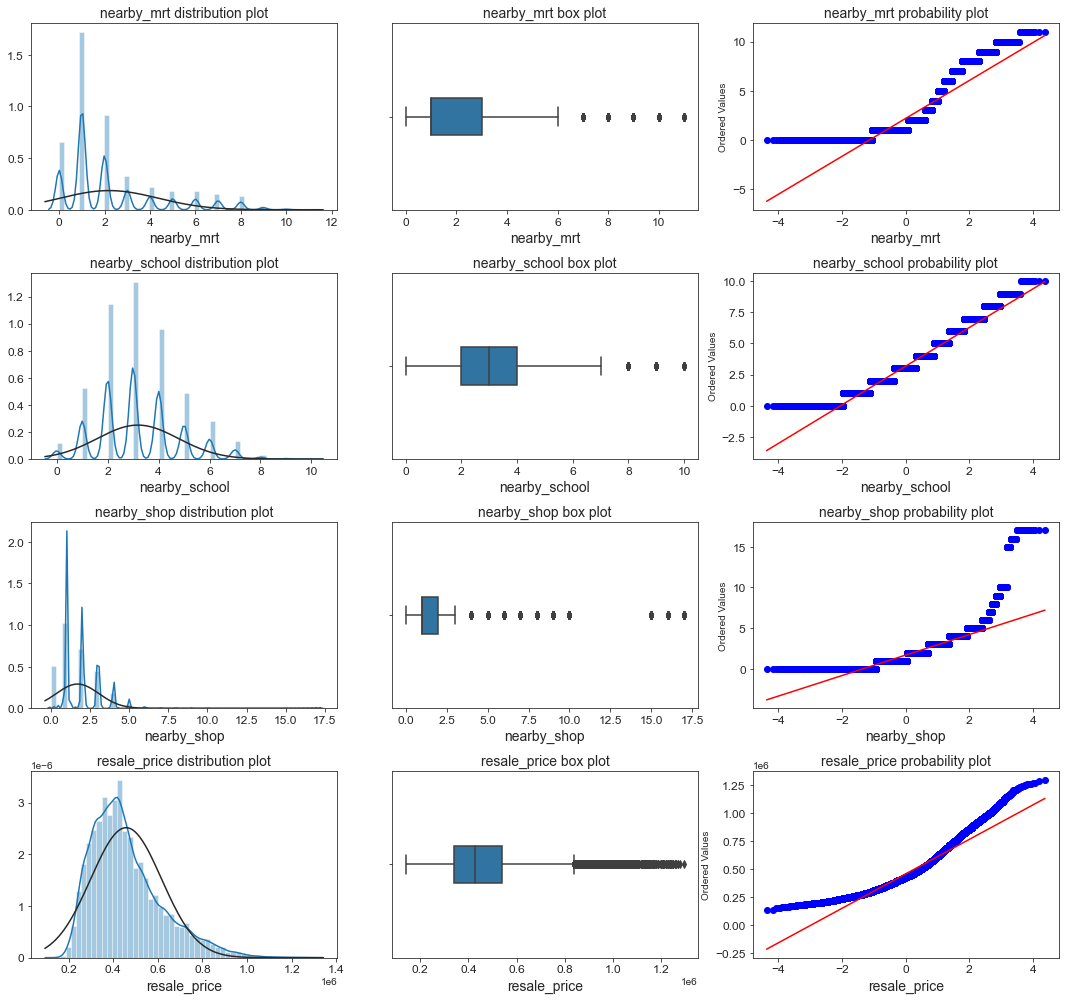

In [32]:
dist_plots(df_price, ['resale_price','nearby_mrt','nearby_school','nearby_shop'])

There is skew for the resale price distribution

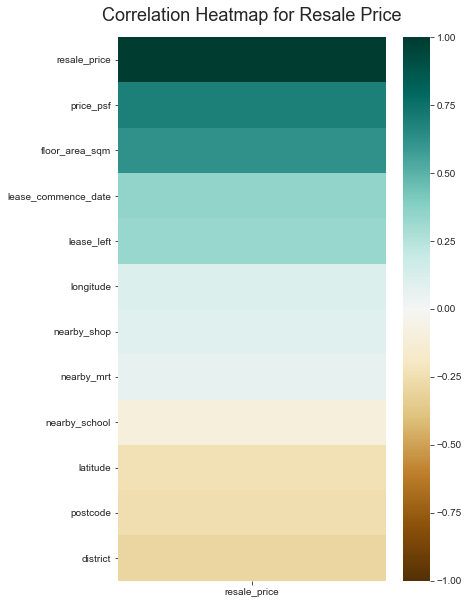

In [33]:
# 5.1 Generate heatmap of the columns with type numbers
num_cols = df_price.select_dtypes(include='number') # Create a dataframe containing only the number columns
plt.figure(figsize=(6, 10))

heatmap = sns.heatmap(num_cols.corr()[['resale_price']].sort_values(by='resale_price', ascending=False), vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Correlation Heatmap for Resale Price', fontdict={'fontsize':18}, pad=16);

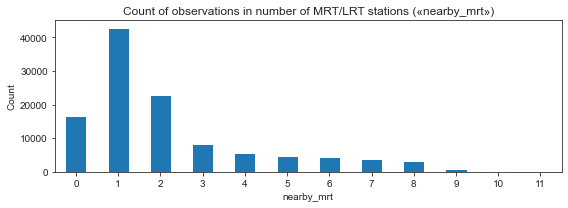

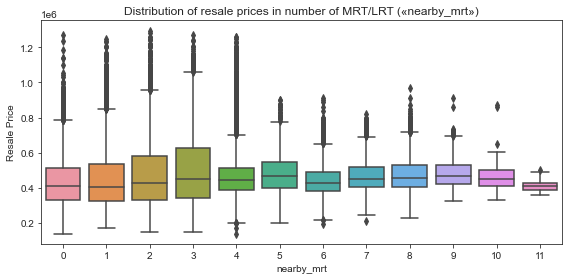

In [34]:
#5.1.1 Explore Nearby MRT vs Resale Price
plt.figure(figsize=(8,3));
df_price.groupby("nearby_mrt")["resale_price"].count().plot(kind="bar")
plt.title("Count of observations in number of MRT/LRT stations («nearby_mrt»)")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4));
ax = sns.boxplot(x="nearby_mrt", y="resale_price", data=df_price)
plt.title("Distribution of resale prices in number of MRT/LRT («nearby_mrt»)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

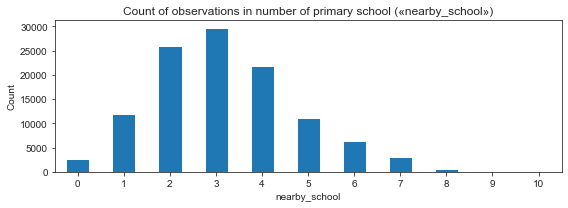

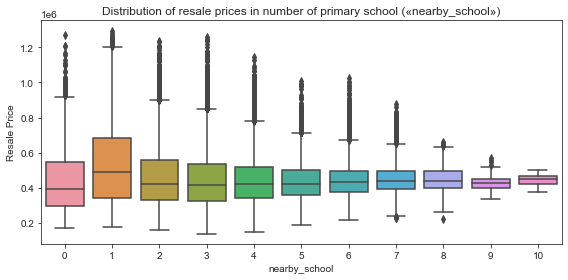

In [35]:
#5.1.2 Explore Nearby primary school vs Resale Price
plt.figure(figsize=(8,3));
df_price.groupby("nearby_school")["resale_price"].count().plot(kind="bar")
plt.title("Count of observations in number of primary school («nearby_school»)")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4));
ax = sns.boxplot(x="nearby_school", y="resale_price", data=df_price)
plt.title("Distribution of resale prices in number of primary school («nearby_school»)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

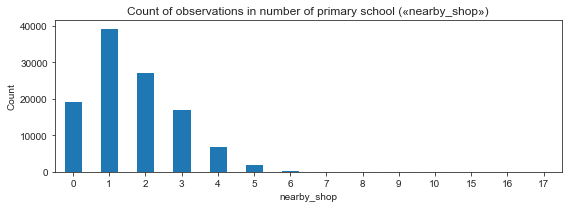

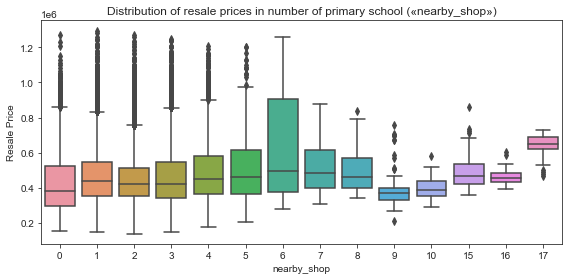

In [36]:
#5.1.3 Explore Nearby shopping center vs Resale Price
plt.figure(figsize=(8,3));
df_price.groupby("nearby_shop")["resale_price"].count().plot(kind="bar")
plt.title("Count of observations in number of primary school («nearby_shop»)")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4));
ax = sns.boxplot(x="nearby_shop", y="resale_price", data=df_price)
plt.title("Distribution of resale prices in number of primary school («nearby_shop»)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

It seems distance to amenities are not strong determinant of resale price shown by large number of prices outside the box.

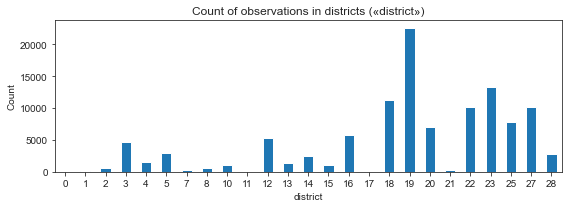

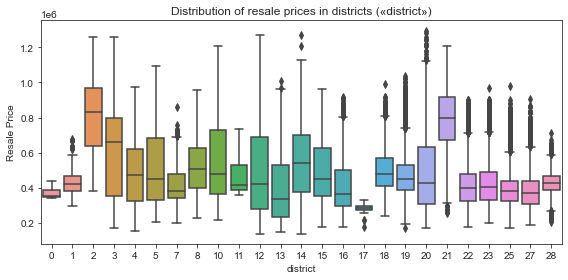

In [37]:
#5.1.4 Explore District vs Resale Price
plt.figure(figsize=(8,3));
df_price.groupby("district")["resale_price"].count().plot(kind="bar")
plt.title("Count of observations in districts («district»)")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4));
ax = sns.boxplot(x="district", y="resale_price", data=df_price)
plt.title("Distribution of resale prices in districts («district»)")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.show()

The Central Area is spread across Districts 1, 2, 6, 7, 9, 10, 11, within the Central Business District (CBD), part of the Core Central Region (CCR), the prices in these districts show less outliers than outside the central area.

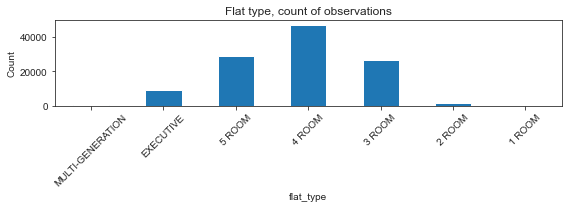

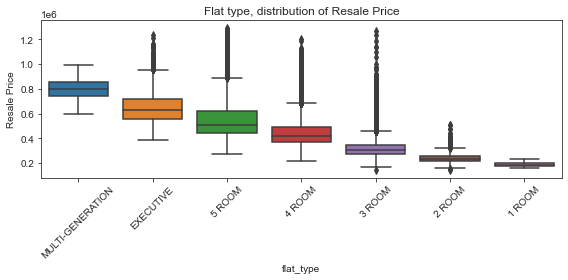

In [38]:
## 5.1.5 Flat_type - Create descending list of flat type according to mean of sale price
# used to sort columns in plots
order = df_price.groupby("flat_type").resale_price.mean().sort_values(ascending=False).index

plt.figure(figsize=(8,3));
df_g = df_price.groupby("flat_type").resale_price.count().sort_values(ascending=False)
df_g = df_g.reindex(order)
df_g.plot(kind="bar")
plt.title("Flat type, count of observations")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4));
ax = sns.boxplot(x="flat_type", y="resale_price", data=df_price, order=order)
plt.title(f"Flat type, distribution of Resale Price")
plt.ylabel("Resale Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most resale flats are 3, 4 and 5 room type. There are many prices outside of the box

# 6.0 Pickle the datasets for the modelling in another notebook

In [39]:
# Save the dataframe as pickle. 
import pickle

print("pickling df_info:", df_info.shape)
picklefile = open('../data/interim/df_info.pickle', 'wb') #create a file
pickle.dump(df_info, picklefile, pickle.HIGHEST_PROTOCOL) #pickle the dataframe
picklefile.close() #close file
print()

# Save the dataframe as pickle. 
print("pickling df_price:", df_price.shape)
picklefile = open('../data/interim/df_price.pickle', 'wb') #create a file
pickle.dump(df_price, picklefile, pickle.HIGHEST_PROTOCOL) #pickle the dataframe
picklefile.close() #close file
print()

# Save the df_mrt_lrt dataframe as pickle. 
print("pickling df_mrt_lrt:", df_mrt_lrt.shape)
picklefile = open('../data/interim/df_mrt_lrt.pickle', 'wb') #create a file
pickle.dump(df_mrt_lrt, picklefile, pickle.HIGHEST_PROTOCOL) #pickle the dataframe
picklefile.close() #close file
print()

# Save the df_school dataframe as pickle. 
print("pickling df_school:", df_school.shape)
picklefile = open('../data/interim/df_school.pickle', 'wb') #create a file
pickle.dump(df_school, picklefile, pickle.HIGHEST_PROTOCOL) #pickle the dataframe
picklefile.close() #close file
print()

# Save the df_shopping dataframe as pickle. 
print("pickling df_shopping:", df_shopping.shape)
picklefile = open('../data/interim/df_shopping.pickle', 'wb') #create a file
pickle.dump(df_shopping, picklefile, pickle.HIGHEST_PROTOCOL) #pickle the dataframe
picklefile.close() #close file
print()

# Save the df_shopping dataframe as pickle. 
print("pickling sg_districts:", sg_districts)
picklefile = open('../data/interim/sg_districts.pickle', 'wb') #create a file
pickle.dump(sg_districts, picklefile, pickle.HIGHEST_PROTOCOL) #pickle the dataframe
picklefile.close() #close file


pickling df_info: (12442, 34)

pickling df_price: (113506, 25)

pickling df_mrt_lrt: (166, 9)

pickling df_school: (184, 8)

pickling df_shopping: (153, 8)

pickling sg_districts: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 14: 3, 15: 3, 16: 3, 9: 4, 10: 4, 11: 5, 12: 5, 13: 5, 17: 6, 18: 7, 19: 7, 20: 8, 21: 8, 22: 9, 23: 9, 24: 10, 25: 10, 26: 10, 27: 10, 28: 11, 29: 11, 30: 11, 31: 12, 32: 12, 33: 12, 34: 13, 35: 13, 36: 13, 37: 13, 38: 14, 39: 14, 40: 14, 41: 14, 42: 15, 43: 15, 44: 15, 45: 15, 46: 16, 47: 16, 48: 16, 49: 17, 50: 17, 81: 17, 51: 18, 52: 18, 53: 19, 54: 19, 55: 19, 82: 19, 56: 20, 57: 20, 58: 21, 59: 21, 60: 22, 61: 22, 62: 22, 63: 22, 64: 22, 65: 23, 66: 23, 67: 23, 68: 23, 69: 24, 70: 24, 71: 24, 72: 25, 73: 25, 77: 26, 78: 26, 75: 27, 76: 27, 79: 28, 80: 28}


In [40]:
# Visualise the singapore district boundaries
import geopandas as gpd
import folium

with open('../data/raw/sla-land-survey-district-kml.geojson') as f:
    json_sg = json.load(f)

m = folium.Map([sg_lat, sg_lon], zoom_start=12)

folium.GeoJson(json_sg).add_to(m)

m


This is the end of part one.